# Identifying roundworm lines

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line

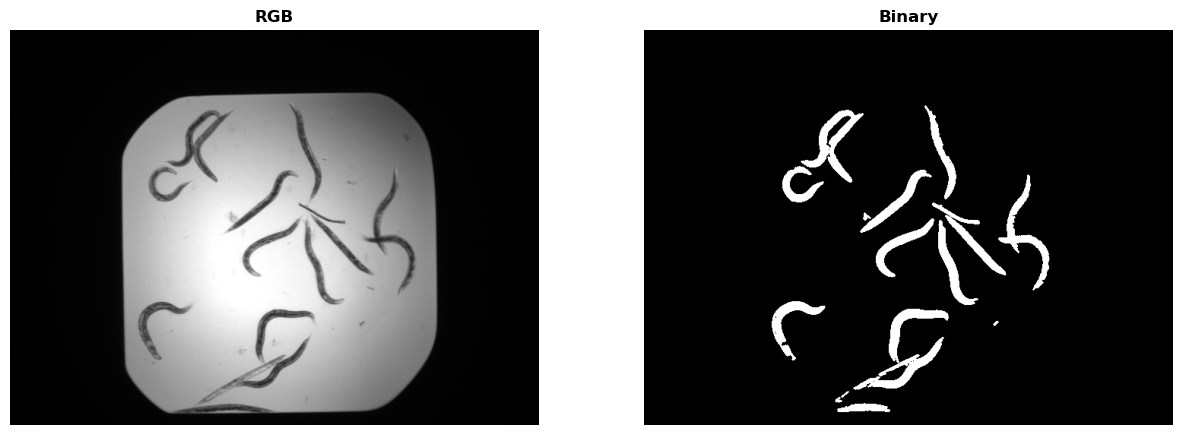

In [2]:
worms = cv2.imread("./images/wormA05.jpg", cv2.IMREAD_GRAYSCALE)
worms_binary = cv2.imread("./images/wormA05BW.jpg", cv2.IMREAD_GRAYSCALE)
_, worms_binary = cv2.threshold(worms_binary, 127, 255, cv2.THRESH_OTSU)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(worms, cmap='gray')
axs[0].axis('off')
axs[0].set_title('RGB')
axs[1].imshow(worms_binary, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Binary')
plt.show()

We will detect straight lines in images of roundworms as a step toward detecting which slides contain live worms. To prevent extraneous lines from being detected, we'll want to skeletonize the image before detecting straight lines.

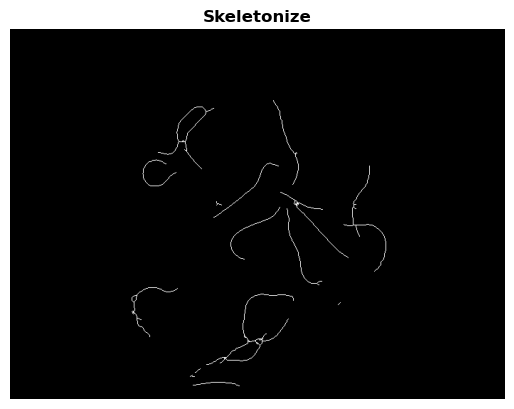

In [3]:
worms_skeletonize = skeletonize(worms_binary / 255)

plt.imshow(worms_skeletonize, cmap='gray')
plt.axis('off')
plt.title('Skeletonize')
plt.show()

Apply Hough transform.

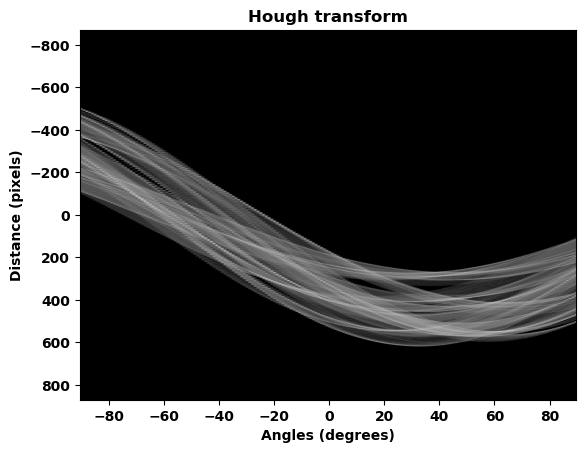

In [4]:
hspace, angles, distance = hough_line(worms_skeletonize)

angle_step = 0.5 * np.diff(angles).mean()
d_step = 0.5 * np.diff(distance).mean()
bounds = [np.rad2deg(angles[0] - angle_step),
          np.rad2deg(angles[-1] + angle_step),
          distance[-1] + d_step, distance[0] - d_step]
plt.imshow(np.log(1 + hspace), extent=bounds, cmap='gray', aspect='auto')
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.show()

Some overlapping lines were detected, that can happen when multiple peaks are found close to each other in the Hough transform. To alter this behavior, we can adjust the minimum distance. In order to avoid detecting overlapping lines, we can increase the size of the minimum distance.

In [5]:
peaks = hough_line_peaks(hspace, angles, distance, min_distance=30, num_peaks=30)
print(f"Number of peaks: {len(peaks[0])}")

Number of peaks: 12


With the peaks detected, you can complete the workflow by plotting the lines.

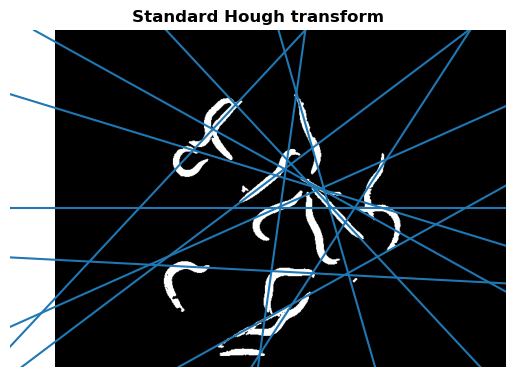

In [6]:
plt.imshow(worms_binary, cmap='gray')
plt.ylim((worms_binary.shape[0], 0))
plt.axis('off')
plt.title('Standard Hough transform')

for _, angle, dist in zip(*peaks):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    plt.axline((x0, y0), slope=np.tan(angle + np.pi/2))

The results is messy because the standard Hough transform doesn't return the the beginning and end of each line segment. Instead we can use the probabilistic Hough transform to obtain them.

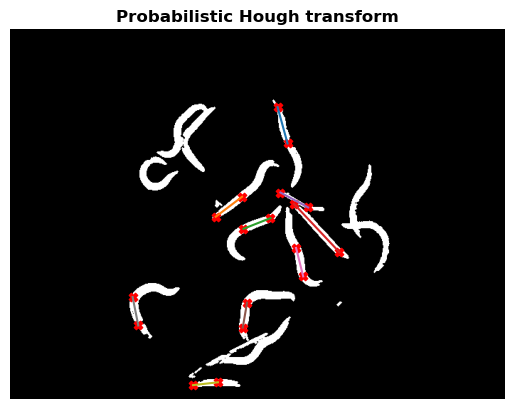

In [7]:
worms_lines = probabilistic_hough_line(worms_skeletonize, threshold=10, line_length=35, line_gap=6, seed=0)

plt.imshow(worms_binary, cmap='gray')
for line in worms_lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
    plt.scatter((p0[0], p1[0]), (p0[1], p1[1]), marker='X', color='red')
plt.axis('off')
plt.title('Probabilistic Hough transform')
plt.show()